## Imports/Setup

In [1]:
%run ../00_functions/00_custom_functions.ipynb
standard_setup(extra_packages=True, verbose=False)
data_ingestion_prep(start_yearmonth='1979-01', end_yearmonth='2022-12', verbose=False)

env: ESMFMKFILE=/home/ds4114/.conda/envs/leap_test202308-3/lib/esmf.mk
Files will be outputed as: .nc
ECMWF CDS API key already installed


## Collection: Atmospheric Carbon (xCO2)

#### NOAA (ESRL)

In [26]:
#xCO2 comes from NOAA. More information: https://gml.noaa.gov/ccgg/trends/gl_data.html

xco2_direct_url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv"
xco2_destination_folder = global_vars['download_folder']+r'xCO2/originals/'
lastmonth_yearmonth = (datetime.date.today().replace(day=1) - datetime.timedelta(days=1)).strftime('%Y%m') #assuming data is updated
xco2_destination_filename = 'xCO2_NOAA_xCO2-mm-gl-monthly_197901-'+lastmonth_yearmonth+'.csv'
download(xco2_direct_url, xco2_destination_folder, xco2_destination_filename) 

Attempting to transfer non-ARCO file extension to cloud...
Saving https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv to ../tmp/xCO2_NOAA_xCO2-mm-gl-monthly_197901-202308.csv...
Complete
Moved to GS gs://leap-persistent/ds4114/online_data/xCO2/originals/xCO2_NOAA_xCO2-mm-gl-monthly_197901-202308.csv.


#### NOAA (Mauna Loa)

In [12]:
#not sure where this file should come from exactly but likely the link below
xco2_mauna_direct_url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
xco2_mauna_destination_folder = global_vars['download_folder']+r'xCO2/originals/'
lastmonth_yearmonth = (datetime.date.today().replace(day=1) - datetime.timedelta(days=1)).strftime('%Y%m') #assuming data is updated
xco2_mauna_destination_filename = 'xCO2_NOAA_xCO2-mm-mlo-monthly_195803-'+lastmonth_yearmonth+'.csv'
download(xco2_mauna_direct_url, xco2_mauna_destination_folder, xco2_mauna_destination_filename) 

Saving https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv to /data/artemis/workspace/ds4114/online_data/xCO2/originals/xCO2_NOAA_xCO2-mm-mlo-monthly_195803-202309.csv...
Complete


## Processing: Atmospheric Carbon (xCO2)

#### NOAA (ESRL)

In [2]:
#data was downloaded monthly as csv. Convert to a xarray
#Note that the number of header rows (55) is hardcoded here
xco2_df = pd.read_csv(global_vars['download_folder']+r'xCO2/originals/xCO2_NOAA_xCO2-mm-gl-monthly_197901-202308.csv', skiprows=55)  
        #previously was xCO2_NOAA_xCO2-mm-gl-monthly_197901-202306.csv
#xco2_df.head(3)

In [43]:
#make time the index; drop unneeded columns; convert to xarray
xco2_df['time'] = xco2_df.apply(lambda row: datetime.datetime(int(row.year), int(row.month), 15), axis=1) #putting as 15th of the month
xco2_df['time'] = pd.to_datetime(xco2_df.time)
xco2_df.index = pd.DatetimeIndex(xco2_df.time)

xco2_xr = xco2_df[['trend']].to_xarray() #we only want the "trend" field because it matches historical work that did not factor seasonality 
xco2_xr_filtered = xco2_xr.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))) #filter for desired time
xco2_xr_filtered = xco2_xr_filtered.rename({'trend': 'xco2_trend'})
#xco2_xr_filtered

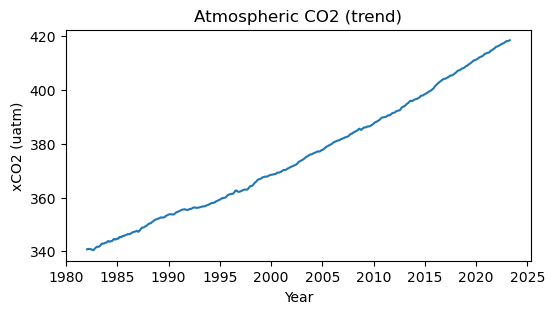

In [45]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.plot(xco2_xr_filtered.time,xco2_xr_filtered.xco2_trend)
plt.title('Atmospheric CO2 (trend)'); plt.xlabel('Year'); plt.ylabel('xCO2 (uatm)');

In [44]:
output_xarray_with_date(xco2_xr_filtered, global_vars['download_folder']+'xCO2/processed/', 'xCO2_NOAA_xCO2-mm-gl-monthly', output_file_type)

Cancelling output - xCO2_NOAA_xCO2-mm-gl-monthly_198201-202304.zarr already exists in gs://leap-persistent/ds4114/online_data/xCO2/processed/


#### Mauna Loa - Back in Time

This requires SST, SLP, and SSS processed data back to 1959 to convert to fco2. I have not downloaded this data so this is just an example of the process/code using prior downloaded files

In [3]:
mauna = pd.read_csv(os.path.join(global_vars['download_folder'],'xCO2/originals/','xCO2_NOAA_xCO2-mm-mlo-monthly_195803-202309.csv'), skiprows=40) #hardcoded rows to skip
esrl = pd.read_csv(os.path.join(global_vars['download_folder'],'xCO2/originals/','xCO2_NOAA_xCO2-mm-gl-monthly_197901-202309.csv'), skiprows=38) #hardcoded rows to skip

In [4]:
#To convert to fco2, requires 3 other datsets we should already have processed

#load processed sst data 
if False: #should be updated to 1959 once but just not processing and downloading all that data so using different file instead
    sst_xr = xr_open_dataset_custom(os.path.join(global_vars['download_folder'],'SST/processed/','SST_ECMWF_ERA5-monthly-reanalysis-1x1-SST_195901-202304.nc')).rename({'sst_era5':'sst'})
else:
    sst_xr = xr.open_dataset(f"/data/artemis/observations/ERA5/processed/ERA5_SST_1x1_mon_1958-2022.nc")
sst = sst_xr.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))).sst

#load processed sss data -
if False: #should be updated to 1959 once but just not processing and downloading all that data so using different file instead
    sss_xr = xr_open_dataset_custom(os.path.join(global_vars['download_folder'],'SSS/processed/','SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_198201-202304.nc'))        
else:
    sss_xr = xr.open_dataset(f"/data/artemis/observations/EN422_salinity/processed/sss_1x1_mon_EN422_195901-202212.nc").rename({'SSS':'sss'})
sss = sss_xr.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))).sss

#load processed mslp data
if False: #actual data is very large (see data collection notes) so this is just an template using the prior processed dataset
    mslp = xr_open_dataset_custom(os.path.join(global_vars['download_folder'],'SLP/processed/','SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_195901-202304.nc')).mslp
else:
    #without downloading full data, we can just use prior version
    mslp = xr.open_dataset(f'/data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-2022.nc').mslp / 100 # Pascals to hPa
mslp = mslp.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth)))

In [5]:
# Create xarrays:
#probably a better way to do the time slicing to organize but the start dates are fixed
ml_dates   = ttime_back_in_time[(ttime_back_in_time >= '1958-03-01') ]
esrl_dates = ttime_back_in_time[(ttime_back_in_time >= '1979-01-01') ] 
mauna_xr = xr.Dataset({ 'xco2':(["time"],mauna[(mauna.year >= 1959) & (mauna.year <= 2022)].average)},
                        coords={'time': (['time'],ml_dates)})
esrl_xr = xr.Dataset({  'xco2':(["time"],esrl[(esrl.year >= 1959) & (esrl.year <= 2022)].average)},
                        coords={'time': (['time'],esrl_dates)})

In [6]:
# Have years 1980/1982 to present directly from ESRL
# Just use offset for prior to 1980 
#UDPATE: using 1982 as cutoff not 1980 to be consistent with other processing (processed_start_yearmonth = '1982-01')

diff_cycle = (mauna_xr.xco2.sel(time=slice(processed_start_yearmonth,processed_end_yearmonth)) \
            - esrl_xr.xco2.sel(time=slice(processed_start_yearmonth,processed_end_yearmonth))).groupby("time.month").mean("time")

global_xco2 = np.empty(shape=(len(ttime_back_in_time))) #1959-2022 monthly

#use difference between mauna loa and esrl for 1980-end to offset early years only available from mauna loa
for yr in range(int(processed_start_yearmonth_back_in_time[0:4]),int(processed_start_yearmonth[0:4])):
    global_xco2[(yr-int(processed_start_yearmonth_back_in_time[0:4]))*12:(yr-int(processed_start_yearmonth_back_in_time[0:4]))*12+12] = \
      mauna_xr.xco2.sel(time=slice(f"01-01-{yr}",f"12-31-{yr}")).values - diff_cycle.values 

#put in real values from esrl for global values
global_xco2[(int(processed_start_yearmonth[0:4])-int(processed_start_yearmonth_back_in_time[0:4]))*12:(int(processed_end_yearmonth[0:4])-int(processed_start_yearmonth_back_in_time[0:4]))*12+12] = \
    esrl_xr.xco2.sel(time=slice(str(processed_start_yearmonth),str(processed_end_yearmonth))).values 

In [7]:
global_xco2_xr = xr.Dataset({'xco2':(["time"],global_xco2),
                        'diff_cycle':(["month"],diff_cycle.values)},
                        coords={'time': (['time'],ttime_back_in_time.values)})
global_xco2_xr['xco2'].attrs['units'] = "ppm"
global_xco2_xr['diff_cycle'].attrs['more info'] = "Mean seasonal cycle of (Mauna Loa - ESRL) for 1982-2022"
global_xco2_xr['diff_cycle'].attrs['units'] = "ppm"
global_xco2_xr.attrs['more_info'] = "Prior to 1982, Global xCO2 estimated by Mauna Loa + Mean Seasonal Cycle of difference between Mauna Loa and ESRL for 1982-2022. After 1982, ESRL is used"
#global_xco2_xr.attrs['created_by'] = "AFay, Mauna_ESRL.ipynb"  

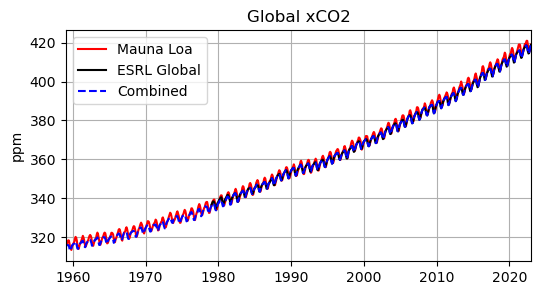

In [8]:
fig = plt.figure(figsize=(figsizew,figsizeh))
plt.plot(mauna_xr.time,mauna_xr.xco2,color='red',label="Mauna Loa")
plt.plot(esrl_xr.time,esrl_xr.xco2,color='black',label="ESRL Global")
plt.plot(ttime_back_in_time.values,global_xco2,'--',color='blue',label='Combined')
plt.grid(True); plt.title("Global xCO2"); plt.ylabel("ppm"); plt.legend()
plt.xlim(min(ttime_back_in_time.values),max(ttime_back_in_time.values));

In [9]:
%%time
pco2 = calc_pco2_from_xco2(global_xco2_xr.xco2,mslp,sst,sss)
mauna_pco2 = calc_pco2_from_xco2( (mauna_xr.xco2.sel(time=slice(processed_start_yearmonth_back_in_time,processed_end_yearmonth)))   ,mslp,sst,sss)
fco2 = pCO2_to_fCO2(pco2, sst, mslp, tempEQ_C=None)
mauna_fco2 = pCO2_to_fCO2(mauna_pco2, sst, mslp, tempEQ_C=None)

/tmp/ipykernel_142847/3375330731.py:60: Warning: There are 8 values that do not fall within the given limits (270, 318.5) of temperature (K)
  warn(msg, Warning)


CPU times: user 19.5 s, sys: 13.7 s, total: 33.2 s
Wall time: 33.3 s


In [10]:
global_pco2_xr = xr.Dataset({
                        'pco2':(["time","ylat","xlon"],pco2.data),
                        'mauna_loa_pco2':(["time","ylat","xlon"],mauna_pco2.data),
                        'fco2':(["time","ylat","xlon"],fco2),
                        'mauna_loa_fco2':(["time","ylat","xlon"],mauna_fco2)},
                        coords={'time': (['time'],global_xco2_xr.time.values),
                               'lat':(['ylat'],sst.ylat.values),
                               'lon':(['xlon'],sst.xlon.values)})

global_pco2_xr['pco2'].attrs['units'] = "micro atm"
global_pco2_xr['pco2'].attrs['more info'] = "Water Vapor Corrected pCO2 using joined Mauna Loa (prior to 1982) and ESRL"
global_pco2_xr['fco2'].attrs['units'] = "micro atm"
global_pco2_xr['fco2'].attrs['more info'] = "Water Vapor Corrected fCO2 using joined Mauna Loa (prior to 1982) and ESRL, converted from pCO2"
global_pco2_xr['mauna_loa_pco2'].attrs['units'] = "micro atm"
global_pco2_xr['mauna_loa_pco2'].attrs['more info'] = "Water Vapor Corrected pCO2 using joined Mauna Loa entire time"
global_pco2_xr['mauna_loa_fco2'].attrs['units'] = "micro atm"
global_pco2_xr['mauna_loa_fco2'].attrs['more info'] = "Water Vapor Corrected fCO2 using joined Mauna Loa entire time"
global_pco2_xr.attrs['more_info'] = "Prior to 1982, Global xCO2 estimated by Mauna Loa + Mean Seasonal Cycle of difference between Mauna Loa and ESRL for 1982-2022. After 1982, ESRL is used"
# global_pco2_xr.attrs['description'] = "NOAA ERSST, EN4.2.1 SSS, ERA5 SLP used to get water vapor correction"
global_pco2_xr.attrs['description'] = "ERA5 SST, EN4.2.1 SSS, ERA5 SLP used to get water vapor correction" #previously val might have used NOAA SST but here she had it set up to ERA.
global_pco2_xr.attrs['created_by'] = "A Fay, Mauna_ESRL.ipynb"  

In [11]:
output_xarray_with_date(global_pco2_xr, os.path.join(global_vars['download_folder'],'xCO2/processed/'), 'xCO2_NOAA_pCO2-fCO2-corrected-ESRL-Mauna', filetype=output_file_type, overwrite=False)

Cancelling output - xCO2_NOAA_pCO2-fCO2-corrected-ESRL-Mauna_195901-202212.nc already exists in /data/artemis/workspace/ds4114/online_data/xCO2/processed/
